In [9]:
%matplotlib inline
import numpy as np
import spacy
import pickle
import nltk
import os
import sklearn.manifold
import matplotlib.pyplot as plt
import pandas as pd
from nltk.cluster import kmeans, euclidean_distance

In [15]:
nlp = spacy.load('es', vectors=False, entity=False)

In [13]:
filename = "input.txt"
#filename = "lavoztextodump.txt"

text_file = open(filename, "r")
dataset = text_file.read()
text_file.close()

In [16]:
doc = nlp(dataset)

In [17]:
sents = [sent for sent in doc.sents if len(sent) > 5]

In [18]:
def parse_tags(word):
    tags = word.tag_[len(word.pos_) + 2:]
    tags = tags.split("|")
    return tags

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/danidebian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
stopwords = nltk.corpus.stopwords.words('spanish')

In [21]:
for word in sents[0]:
    if word.lemma_ in stopwords:
        print(word.lemma_)

lo
a
la
es
el


In [22]:
# Crear diccionario
dicc = []
list_dicc = {}
word_id = 0

for sent in sents:
    for word in sent:
        w = word.lemma_
        if not word.is_alpha:
            continue
        if not w in list_dicc:
            list_dicc[w] = word_id
            contexts = {}
        else:
            idw = list_dicc[w]
            contexts = dicc[idw]
        
        pos = "POS__" + word.pos_
        if not pos in contexts:
            contexts[pos] = 0
        contexts[pos] += 1
        
        dep = "DEP__" + word.dep_
        if not dep in contexts:
            contexts[dep] = 0
        contexts[dep] += 1
        
        tags = parse_tags(word)
        for tag in tags:
            if not tag in contexts:
                contexts[tag] = 0
            contexts[tag] += 1
        
        for context in sent:
            c = context.lemma_
            if not context.is_alpha or c == w or c in stopwords:
                continue
            if not c in contexts:
                contexts[c] = 0
            contexts[c] += 1
                
        word_id += 1
        dicc.append(contexts)

In [24]:
print(list_dicc)
print(dicc)

{'la': 4, 'lo': 0, 'el': 7, 'sostiene': 2, 'pareja': 5, 'amor': 8, 'qu': 1, 'es': 6, 'a': 3}
[{'POS__PRON': 1, 'Gender=Masc': 1, 'pareja': 1, 'Number=Sing': 1, 'PronType=Prs': 1, 'Case=Acc': 1, 'Person=3': 1, 'sostiene': 1, 'amor': 1, 'DEP__det': 1, 'qu': 1}, {'POS__PRON': 1, 'amor': 1, 'pareja': 1, 'sostiene': 1, 'PronType=Rel': 1, 'DEP__obj': 1}, {'amor': 1, 'Tense=Pres': 1, 'Mood=Ind': 1, 'pareja': 1, 'Number=Sing': 1, 'VerbForm=Fin': 1, 'Person=3': 1, 'POS__VERB': 1, 'DEP__csubj': 1, 'qu': 1}, {'pareja': 1, 'POS__ADP': 1, 'sostiene': 1, 'AdpType=Prep': 1, 'amor': 1, 'DEP__case': 1, 'qu': 1}, {'Gender=Fem': 1, 'Definite=Def': 1, 'Number=Sing': 1, 'PronType=Art': 1, 'qu': 1, 'sostiene': 1, 'pareja': 1, 'amor': 1, 'POS__DET': 1, 'DEP__det': 1}, {'Gender=Fem': 1, 'POS__NOUN': 1, 'Number=Sing': 1, 'sostiene': 1, 'amor': 1, 'qu': 1, 'DEP__obj': 1}, {'amor': 1, 'Tense=Pres': 1, 'pareja': 1, 'Number=Sing': 1, 'VerbForm=Fin': 1, 'Person=3': 1, 'sostiene': 1, 'Mood=Ind': 1, 'DEP__cop': 1, 'P

In [3]:
# No ejecutar
filename = "lavoz_dicc.pickle"
fileObj = open(filename, 'wb')

pickle.dump(dicc, fileObj)
fileObj.close()

NameError: name 'dicc' is not defined

In [150]:
filename = "lavoz_dicc.pickle"
with open(filename, 'rb') as f:
    # load using pickle de-serializer
    dictionary = pickle.load(f)

In [151]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(dictionary)

In [152]:
# NO EJECUTAR
filename = "lavoz_matrix.pickle"
fileObj = open(filename, 'wb')

pickle.dump(matrix, fileObj)
fileObj.close()

In [4]:
# Cargar matriz
filename = "lavoz_matrix.pickle"
with open(filename, 'rb') as f:
    # load using pickle de-serializer
    m = pickle.load(f)

In [5]:
print(m.shape)

(403, 284)


In [75]:
matrix_normed = matrix / matrix.max(axis=0)

In [85]:
print(matrix_normed[0])

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          0.
  0.1         0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.05882353
  0.          0.          0.          1.          0.          0.66666667
  0.          0.          1.          1.          0.5         0.          1.
  0.5         0.74        1.          0.5         0.66666667  0.53846154
  0.66666667  0.5         0.66666667  0.2         1.          0.66666667
  0.25        0.66666667  0.625       1.          0.66666667  1.          1.
  1.          1.          0.33333333  1.          0.5         0.66666667
  1.          1.          0.          0.66666667  0.66666667  1.          1.
  0.57142857  0.          1.          1.          1.          0.          0.
  0.66666667  1.   

In [8]:
# Agregar contextos
for word in dicc:
    word_id = list_dicc[word]
    for ctx in dicc[word]['CONTEXT']:
        ctx_id = list_dicc[ctx]
        occ = dicc[word]['CONTEXT'][ctx]
        matrix_dicc[word_id][ctx_id] = occ
    """     
    for pos in dicc[word]['POS']:
        pos_id = list_pos[pos]
        occ = dicc[word]['POS'][pos]
        print(pos_id, len(dicc))
        #matrix_dicc[word_id][pos_id + len(dicc)] = occ
    """  

print(matrix_dicc)

[[   0.   72.  458. ...,    0.    0.    0.]
 [  72.    0.   33. ...,    0.    0.    0.]
 [ 458.   33.    0. ...,    0.    0.    0.]
 ..., 
 [   2.    0.    0. ...,    0.    0.    0.]
 [   2.    0.    0. ...,    0.    0.    0.]
 [   2.    0.    0. ...,    0.    0.    0.]]


In [77]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

matrix_dicc2d = tsne.fit_transform(matrix_normed)

In [78]:
pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[list_dicc[word]])
            for word in list_dicc
        ]
    ],
    columns=["word", "x", "y"]
)

In [371]:
# Diccionario de contextos

contextos = {}

for sent in sents:
    for word_id, word in enumerate(sent):
        if word_id == 0:
            ctx1 = None
        else:
            ctx1 = sent[word_id - 1].lemma_
        if word_id == len(sent) - 1:
            ctx2 = None
        else:
            ctx2 = sent[word_id + 1].lemma_
        if not (ctx1, ctx2) in contextos:
            contextos[(ctx1, ctx2)] = {}
        if not word.lemma_ in contextos[(ctx1, ctx2)]:
            contextos[(ctx1, ctx2)][word.lemma_] = 0
        contextos[(ctx1, ctx2)][word.lemma_] += 1
        
print(contextos)

{('una', 'y'): {'oración': 1}, ('y', 'este'): {'tiene': 1}, ('este', 'muy'): {'texto': 1}, ('española', 'varios'): {'tiene': 1}, ('de', 'real'): {'la': 1}, ('con', 'de'): {'más': 1}, ('roberto', '55'): {'(': 1}, ('real', 'española'): {'academia': 2}, ('más', 'cinco'): {'de': 1}, ('texto', 'más'): {'con': 1}, ('textos', None): {'.': 1}, ('academia', 'tiene'): {'española': 1}, ('es', 'y'): {'española': 1}, ('el', '.'): {'tema': 1}, ('academia', 'de'): {'española': 1}, ('palabras', None): {'.': 1}, (None, '('): {'clara': 1}, (None, 'real'): {'la': 1}, (')', 'roberto'): {'y': 1}, ('clara', '54'): {'(': 1}, ('un', 'con'): {'texto': 1}, (None, 'es'): {'ella': 1, 'este': 1, 'ésta': 1}, ('ésta', 'una'): {'es': 1}, ('es', 'texto'): {'un': 1}, ('54', 'y'): {')': 1}, ('55', ','): {')': 1}, ('tiene', 'texto'): {'este': 1}, ('de', 'palabras'): {'cinco': 1}, ('la', 'academia'): {'real': 2}, ('largo', None): {'.': 1}, ('muy', '.'): {'largo': 1}, ('de', '.'): {'prueba': 1}, ('oración', 'un'): {'y': 1}

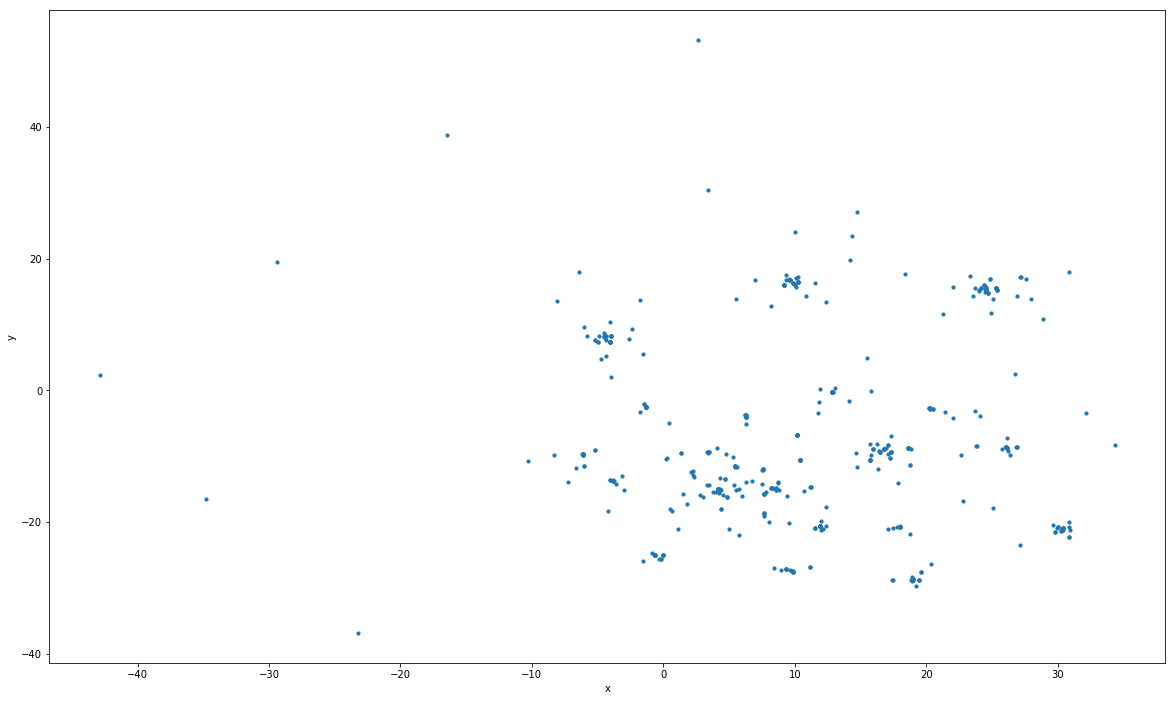

In [79]:
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [61]:
def plot_region(x_bounds, y_bounds):
    slice = pointsspacy[
        (x_bounds[0] <= pointsspacy.x) &
        (pointsspacy.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointsspacy.y) &
        (pointsspacy.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

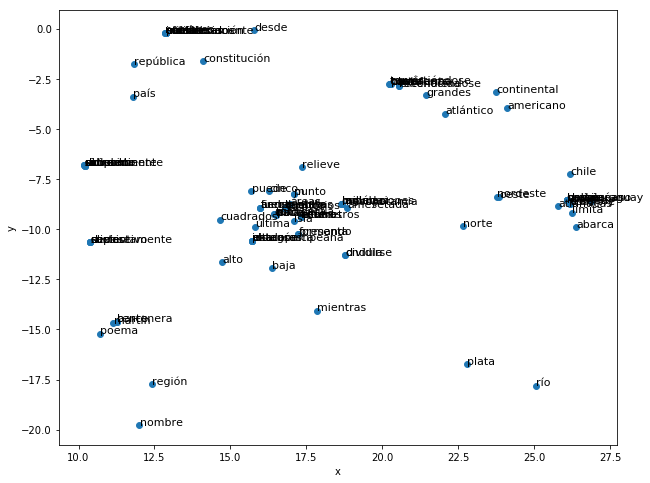

In [80]:
plot_region(x_bounds=(10, 30), y_bounds=(-20, 0))

In [58]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/dani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [59]:
text_file = open("lavoztextodump.txt", "r")
dataset = text_file.read()
text_file.close()

tokenizer = nltk.data.load('tokenizers/punkt/spanish.pickle')
sentences = tokenizer.tokenize(dataset)

print(sentences[:30])

['-\n"Lo que sostiene a la pareja es el amor"\nClara Crespo (50) y Rodolfo Martínez (54) no se imaginan uno sin el otro.', '"Prefiero ni pensarlo", dice Clara.', 'Hace 26 años que están casados, y tienen cuatro hijas mujeres.', 'Se conocieron en el Ateneo Juventus, el movimiento juvenil de Capuchinos.', 'Hoy aseguran no estar sorprendidos del tiempo que llevan juntos sino de haber logrado entenderse tan bien.', '&#226;&#8364;&#8220;¿Qué les gusta y disgusta del otro?', '¿Qué quisieran cambiarle?', '&#226;&#8364;&#8220;Rodolfo: Me gusta que sea cariñosa, alegre y esté siempre pensando en mí, y que es una gran madre.', 'Me disgustaba que cuando se enojaba no quería hablar, pero ya no lo hace más.', 'A veces es indecisa pero ya me acostumbré.', 'No quiero cambiarle nada, que sea como es.', '&#226;&#8364;&#8220;Clara : Me gusta que es una persona emprendedora, alegre, optimista y servicial.', 'Me gustaría que a veces fuera más sutil para decir las cosas.', 'Pienso que las personas vamos ca

In [60]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-ZñÑÁÉÍÓÚáéíóúü]"," ", raw)
    words = clean.split()
    return words

In [61]:
tokens = []
for sentence in sentences:
    tokens.append(sentence_to_wordlist(sentence))
    
print(tokens[:10])

[['Lo', 'que', 'sostiene', 'a', 'la', 'pareja', 'es', 'el', 'amor', 'Clara', 'Crespo', 'y', 'Rodolfo', 'Martínez', 'no', 'se', 'imaginan', 'uno', 'sin', 'el', 'otro'], ['Prefiero', 'ni', 'pensarlo', 'dice', 'Clara'], ['Hace', 'años', 'que', 'están', 'casados', 'y', 'tienen', 'cuatro', 'hijas', 'mujeres'], ['Se', 'conocieron', 'en', 'el', 'Ateneo', 'Juventus', 'el', 'movimiento', 'juvenil', 'de', 'Capuchinos'], ['Hoy', 'aseguran', 'no', 'estar', 'sorprendidos', 'del', 'tiempo', 'que', 'llevan', 'juntos', 'sino', 'de', 'haber', 'logrado', 'entenderse', 'tan', 'bien'], ['Qué', 'les', 'gusta', 'y', 'disgusta', 'del', 'otro'], ['Qué', 'quisieran', 'cambiarle'], ['Rodolfo', 'Me', 'gusta', 'que', 'sea', 'cariñosa', 'alegre', 'y', 'esté', 'siempre', 'pensando', 'en', 'mí', 'y', 'que', 'es', 'una', 'gran', 'madre'], ['Me', 'disgustaba', 'que', 'cuando', 'se', 'enojaba', 'no', 'quería', 'hablar', 'pero', 'ya', 'no', 'lo', 'hace', 'más'], ['A', 'veces', 'es', 'indecisa', 'pero', 'ya', 'me', 'acos

Eliminamos oraciones con menos de 5 palabras

In [64]:
sents = [sent for sent in tokens if len(sent) > 5]

print(sents[:20])

[['Lo', 'que', 'sostiene', 'a', 'la', 'pareja', 'es', 'el', 'amor', 'Clara', 'Crespo', 'y', 'Rodolfo', 'Martínez', 'no', 'se', 'imaginan', 'uno', 'sin', 'el', 'otro'], ['Hace', 'años', 'que', 'están', 'casados', 'y', 'tienen', 'cuatro', 'hijas', 'mujeres'], ['Se', 'conocieron', 'en', 'el', 'Ateneo', 'Juventus', 'el', 'movimiento', 'juvenil', 'de', 'Capuchinos'], ['Hoy', 'aseguran', 'no', 'estar', 'sorprendidos', 'del', 'tiempo', 'que', 'llevan', 'juntos', 'sino', 'de', 'haber', 'logrado', 'entenderse', 'tan', 'bien'], ['Qué', 'les', 'gusta', 'y', 'disgusta', 'del', 'otro'], ['Rodolfo', 'Me', 'gusta', 'que', 'sea', 'cariñosa', 'alegre', 'y', 'esté', 'siempre', 'pensando', 'en', 'mí', 'y', 'que', 'es', 'una', 'gran', 'madre'], ['Me', 'disgustaba', 'que', 'cuando', 'se', 'enojaba', 'no', 'quería', 'hablar', 'pero', 'ya', 'no', 'lo', 'hace', 'más'], ['A', 'veces', 'es', 'indecisa', 'pero', 'ya', 'me', 'acostumbré'], ['No', 'quiero', 'cambiarle', 'nada', 'que', 'sea', 'como', 'es'], ['Clara

[[('Lo', 'da0ns0'), ('que', 'pr0cn000'), ('sostiene', 'vmip3s0'), ('a', 'sps00'), ('la', 'da0fs0'), ('pareja', 'ncfs000'), ('es', 'vsip3s0'), ('el', 'da0ms0'), ('amor', 'ncms000'), ('Clara', None), ('Crespo', None), ('50', 'Z'), ('y', 'cc'), ('Rodolfo', None), ('Martínez', None), ('54', 'Z'), ('no', 'rn'), ('se', 'p0300000'), ('imaginan', None), ('uno', 'pi0ms000'), ('sin', 'sps00'), ('el', 'da0ms0'), ('otro', 'di0ms0')], [('Prefiero', None), ('ni', 'cc'), ('pensarlo', 'vmn0000'), ('dice', 'vmip3s0'), ('Clara', None)], [('Hace', 'vmip3s0'), ('26', 'Z'), ('años', 'ncmp000'), ('que', 'pr0cn000'), ('están', 'vmip3p0'), ('casados', 'ncmp000'), ('y', 'cc'), ('tienen', 'vmip3p0'), ('cuatro', 'dn0cp0'), ('hijas', 'ncfp000'), ('mujeres', 'ncfp000')], [('Se', 'p0000000'), ('conocieron', 'vmis3p0'), ('en', 'sps00'), ('el', 'da0ms0'), ('Ateneo', None), ('Juventus', 'np0000o'), ('el', 'da0ms0'), ('movimiento', 'ncms000'), ('juvenil', 'aq0cs0'), ('de', 'sps00'), ('Capuchinos', None)], [('Hoy', 'rg'

In [90]:
stopwords = nltk.corpus.stopwords.words('spanish')

print(stopwords)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosostros', 'vosostras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 

In [ ]:
stemmer = nltk.stem.SnowballStemmer('spanish')
stemmed = [(stemmer.stem(word[0]), word[1]) for word in sentence in tagged]

In [92]:
filtered = []
for sentence in tokens:
    filtered.append([e.lower() for e in sentence if not e.lower() in stopwords])

In [94]:
print(filtered[0:4])

[['sostiene', 'pareja', 'amor', 'clara', 'crespo', 'rodolfo', 'martínez', 'imaginan'], ['prefiero', 'pensarlo', 'dice', 'clara'], ['hace', 'años', 'casados', 'cuatro', 'hijas', 'mujeres'], ['conocieron', 'ateneo', 'juventus', 'movimiento', 'juvenil', 'capuchinos']]


In [7]:
features = 300
min_word_count = 3
workers = multiprocessing.cpu_count()
downsampling = 1e-3
window_size = 7
seed = 1

In [8]:
model = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=workers,
    size=features,
    min_count=min_word_count,
    window=window_size,
    sample=downsampling
)

model.build_vocab(tokens)
model.train(tokens, total_examples=model.corpus_count, epochs=5)
print('amor', model.wv['amor'])

Using Theano backend.


amor [ 0.0019081   0.03788329  0.0732977  -0.08875214  0.00787262 -0.27142045
 -0.03012004  0.33160967  0.22336468 -0.14190604 -0.26700467  0.15937614
 -0.13973366 -0.07926508  0.29873046  0.18393791 -0.50901395  0.11233066
 -0.24048172  0.08032653 -0.12766637 -0.18000585 -0.07272971  0.21804319
 -0.14217573 -0.03138161  0.0525399   0.19050172 -0.47128198 -0.22440229
  0.62092721  0.22778834 -0.56251252 -0.10750446  0.21095461  0.17801301
 -0.03459159  0.43187988  0.00487325 -0.28591847 -0.06070664 -0.13260424
 -0.12072115 -0.23953161 -0.34951985  0.38018873 -0.04595491  0.15575568
 -0.51880705 -0.07733829 -0.03748027  0.15459187  0.1809691  -0.50386339
  0.17809829 -0.23940893  0.22080702  0.13428482 -0.04161387  0.37537429
 -0.0543808   0.08422869  0.23982562 -0.21166983 -0.06652743 -0.01518933
  0.03355731 -0.44776052  0.16222991  0.06011346  0.04918561 -0.03595895
  0.19789532  0.62498581 -0.03296425  0.08821586 -0.00839806 -0.06371783
 -0.08578367 -0.52892888 -0.0496099  -0.343194

In [9]:
print(model.wv.most_similar(positive=['realizar', 'bailó'], negative=['bailar']))
print(model.wv.similarity('mujer', 'hombre'))
print(model.wv.similarity('canción', 'música'))
print(model.wv.similarity('amor', 'inversión'))
print(model.wv.doesnt_match("pareja amor querido querida inversión".split()))

[('constituirán', 0.5769941806793213), ('Railways', 0.5665370225906372), ('enmarcó', 0.5623599290847778), ('salteña', 0.5584231615066528), ('Agroalimentario', 0.5575581192970276), ('recaudadora', 0.5555493831634521), ('colaborará', 0.5550211668014526), ('emitiera', 0.5541412830352783), ('pionero', 0.5540026426315308), ('Investigadora', 0.5514497756958008)]
0.590750943695
0.466844372523
0.14797705857
inversión
0.164495132102


In [10]:
if not os.path.exists("trained"):
    os.makedirs("trained")

model.save(os.path.join("trained", "model.w2v"))

In [4]:
model = w2v.Word2Vec.load(os.path.join("trained", "model.w2v"))

tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

matrix = model.wv.syn0

matrix2d = tsne.fit_transform(matrix)

In [12]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix2d[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [13]:
print(points.head())

         word          x          y
0     Clarita -13.067820  12.924535
1   estallido  25.759460 -14.030043
2  franquista  19.965641 -14.220193
3     recrear -27.542164  -6.170426
4    evitarla -22.971474   5.860813


<class 'pandas.core.frame.DataFrame'>


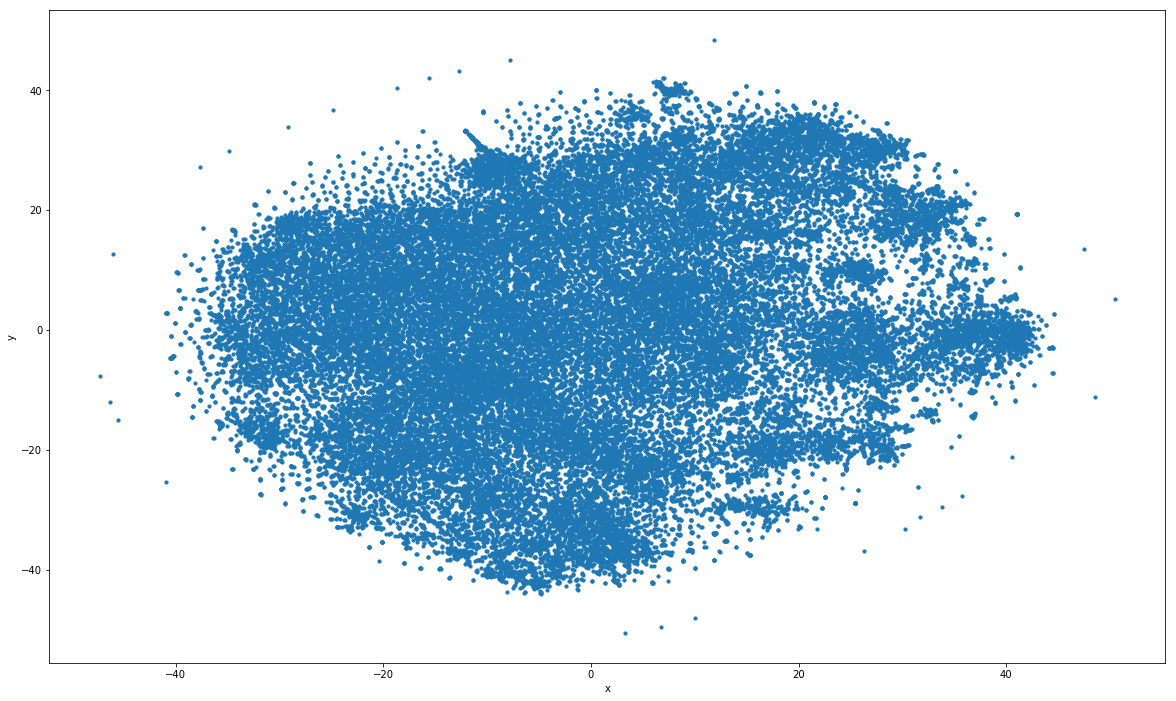

In [14]:
print(type(points))
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [5]:
clusterer = kmeans.KMeansClusterer(4, euclidean_distance)
clusters = clusterer.cluster(model.wv.syn0, True)

In [13]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix2d[model.wv.vocab[word].index], clusters[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y", "c"]
)

In [11]:
print(points.head())

       word          x          y  c
0   seguras -21.395166 -24.605179  1
1  Nafziger  -0.899111  25.860342  4
2   agrupar -17.663458 -21.141586  1
3   cerraba   3.822260   6.200396  4
4    laburo -26.092129  13.893674  4


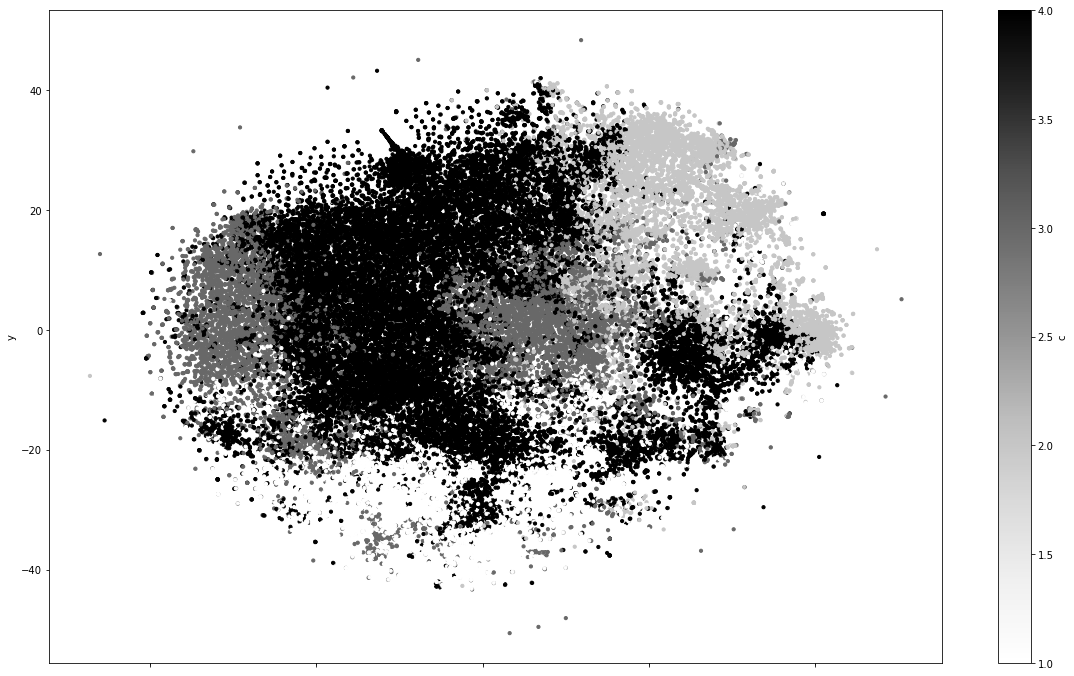

In [12]:
points.plot(kind='scatter', x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

In [39]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', c='c', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

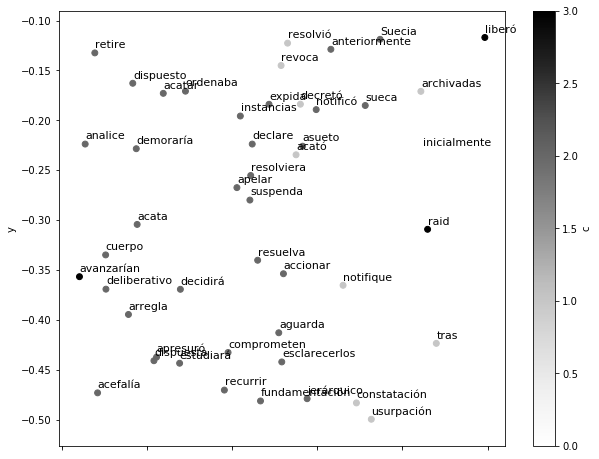

In [40]:
plot_region(x_bounds=(10, 20), y_bounds=(-0.5, -0.1))